### 문제 6-1 : 간단한 카페 주문 워크플로우 구현

In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
import re
import os, json

from textwrap import dedent
from pprint import pprint

import warnings
warnings.filterwarnings("ignore")

In [3]:
def load_menu_from_txt(file_path: str) -> dict:
    menu = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    name = None
    for line in lines:
        line = line.strip()
        if re.match(r'^\d+\.\s', line):  
            name = line.split(". ")[1].strip()
        elif "가격" in line and name:
            match = re.search(r'₩([0-9,]+)', line)
            if match:
                price = int(match.group(1).replace(",", ""))
                menu[name] = price
                name = None  

    return menu


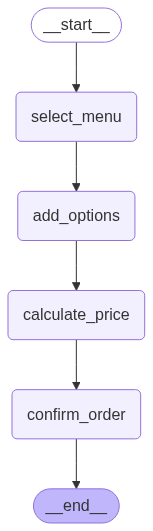

In [6]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

MENU_PRICES = load_menu_from_txt("../data/cafe_menu_data.txt")

class OrderState(TypedDict):
    selected_menu: str
    options: List[str]
    total_price: int
    order_confirmed: bool

OPTION_PRICES = {
    "샷 추가": 500,
    "휘핑크림 추가": 300,
    "시럽 추가": 200
}

def select_menu(state: OrderState) -> OrderState:
    menu_name = list(MENU_PRICES.keys())[0]  
    print(f"- 메뉴 선택: {menu_name}")
    return {"selected_menu": menu_name}

def add_options(state: OrderState) -> OrderState:
    options = ["샷 추가", "시럽 추가"]
    print(f"- 옵션 추가: {options}")
    return {"options": options}

def calculate_price(state: OrderState) -> OrderState:
    base_price = MENU_PRICES.get(state["selected_menu"], 0)
    option_price = sum(OPTION_PRICES.get(opt, 0) for opt in state["options"])
    total = base_price + option_price
    print(f"- 가격 계산: {base_price} + {option_price} = {total}원")
    return {"total_price": total}

def confirm_order(state: OrderState) -> OrderState:
    print(f"- 주문 확인: {state['selected_menu']} + {state['options']} → 총 {state['total_price']}원")
    return {"order_confirmed": True}

builder = StateGraph(OrderState)
builder.add_node("select_menu", select_menu)
builder.add_node("add_options", add_options)
builder.add_node("calculate_price", calculate_price)
builder.add_node("confirm_order", confirm_order)

builder.add_edge(START, "select_menu")
builder.add_edge("select_menu", "add_options")
builder.add_edge("add_options", "calculate_price")
builder.add_edge("calculate_price", "confirm_order")
builder.add_edge("confirm_order", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
initial_state = {
    "selected_menu": "",
    "options": [],
    "total_price": 0,
    "order_confirmed": False
}

final_state = graph.invoke(initial_state)

print("\n==> 최종 상태:", final_state)


- 메뉴 선택: 아메리카노
- 옵션 추가: ['샷 추가', '시럽 추가']
- 가격 계산: 4500 + 700 = 5200원
- 주문 확인: 아메리카노 + ['샷 추가', '시럽 추가'] → 총 5200원

==> 최종 상태: {'selected_menu': '아메리카노', 'options': ['샷 추가', '시럽 추가'], 'total_price': 5200, 'order_confirmed': True}
